#DiaSources Analysis

In [2]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import lsst.afw.geom as afwGeom
import lsst.afw.display.utils as displayUtils

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This is the butler reference that we use on our working dataset. DATADIR is where our data is, obviously

In [3]:
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")


We create a list with all our diaSources Catalog (one for each visit)

In [4]:
subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            

#file.close()

In [5]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)

In [27]:
ds9.mtv(diffExp, frame=1)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [71]:
fluxes = []
fluxesCtr = []
fluxesNeg = []
fluxesPos = []
sourcesCtr = []
sourcesNeg = []
sourcesPos = []

sigmaPos = []
sigmaNeg = []

for diaSrc in diaSrcs:
    
    flux = diaSrc.get("base_PeakLikelihoodFlux_flux")
    #ds9.dot("o", x, y, size = 25, frame=3)
    x = diaSrc.get("ip_diffim_NaiveDipoleCentroid_x")
    y = diaSrc.get("ip_diffim_NaiveDipoleCentroid_y")
    if np.abs(flux) < 50000:
        fluxes.append(flux)
        if np.abs(flux) <= 10000:
            fluxesCtr.append(flux)
        elif flux > 10000:
            fluxesPos.append(flux)
        else:
            fluxesNeg.append(flux)
        
        
    if np.abs(flux) <= 10000:
        sourcesCtr.append(diaSrc)
        ds9.dot("o", x, y, size = 25, frame=3, ctype="BLUE")
    elif flux > 10000:
        sourcesPos.append(diaSrc)
        ds9.dot("o", x, y, size = 25, frame=3, ctype="GREEN")
    else:
        sourcesNeg.append(diaSrc)
        ds9.dot("o", x, y, size = 25, frame=3, ctype="RED")
        
    if flux > 0:
        sigmaPos.append(diaSrc.get("base_PeakLikelihoodFlux_fluxSigma"))
    else:
        sigmaNeg.append(diaSrc.get("base_PeakLikelihoodFlux_fluxSigma"))               
    
    
ds = random.choice(diaSrcs)

In [77]:
meanSigmaPos = np.mean(sigmaPos)
meanSigmaNeg = np.mean(sigmaNeg)

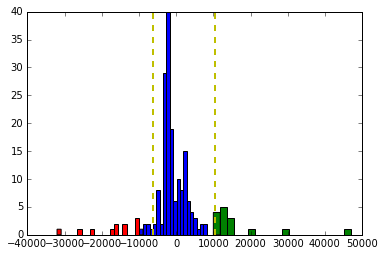

In [79]:
plt.hist(fluxesCtr, bins=20)
plt.hist(fluxesPos, bins=20)
plt.hist(fluxesNeg, bins=20)
plt.axvline(meanSigmaPos*5, color='y', linestyle='dashed', linewidth=2)
plt.axvline(-(meanSigmaNeg*5), color='y', linestyle='dashed', linewidth=2)
plt.show()
    

In [30]:
len(diaSrcs)

198

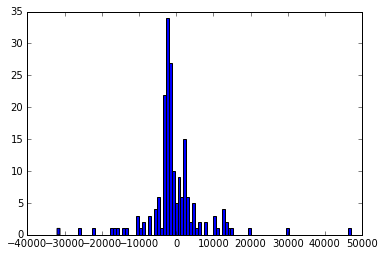

In [20]:
%matplotlib inline


plt.hist(fluxes, bins=100)
plt.show()

In [21]:
templateExposure = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})

In [55]:

scienceExposure =  butler.get("calexp", {"visit":800719, "ccd":14, "filter":"r"})
templateExposure = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})
subtractedExposure = diffExp

ds9.mtv(scienceExposure, frame=1)
ds9.mtv(templateExposure, frame=2)
ds9.mtv(subtractedExposure, frame=3)

In [46]:
ds = random.choice(diaSrcs)

In [47]:
bbox = ds.getFootprint().getBBox()

mos = displayUtils.Mosaic()
Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())

ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)



correctedBegin = bbox.getBegin()- ExpOrig
correctedEnd = bbox.getEnd() - ExpOrig

correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )
    
    
    
bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)
   
#print bboxT.toString
stamp = scienceExposure.Factory(scienceExposure,bboxT, True)
im = displayUtils.Mosaic(gutter=5, background=5, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=4)

#mos.append(im.makeMosaic())
#mosaicImage = mos.makeMosaic(frame=1, title="mosaic")

In [48]:
stamp = templateExposure.Factory(templateExposure,bboxT, True)
#im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=5)


stamp = subtractedExposure.Factory(subtractedExposure,bboxT, True)
#im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=6)

In [49]:
im.makeMosaic(frame=7, title="mosaic")

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f06ea5974b0> >

In [50]:
bX = bboxT.getBeginX()
bY = bboxT.getBeginY()
eX = bboxT.getEndX()
eY = bboxT.getEndY()
   
ds9.line([(bX,bY), (bX, eY)], frame=1,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=1,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=1,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=1,ctype='red')

ds9.line([(bX,bY), (bX, eY)], frame=2,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=2,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=2,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=2,ctype='red')

ds9.line([(bX,bY), (bX, eY)], frame=3,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=3,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=3,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=3,ctype='red')


Some tests, obtaining the instances for the list of diaSources for three different visits

In [9]:
dCatalog1 = diaSourcesList[0]
dCatalog2 = diaSourcesList[1]
dCatalog3 = diaSourcesList[2]


#diaSources =  diaSourcesCatalog.get("deepDiff_diaSrc")
       
        
diaSrcs1 = dCatalog1.get("deepDiff_diaSrc")
diaSrcs2 = dCatalog2.get("deepDiff_diaSrc")
diaSrcs3 = dCatalog3.get("deepDiff_diaSrc")

Method to match two catalogs in terms of sources

In [5]:
smVector = afwTable.matchXy(diaSrcs1, diaSrcs2, 1000, True)

Method to plot the fluxes of any diaSources by giving the visit number

In [10]:
def plot_fluxes(diaSourcesList, visit=-1, max_flux=1000, bins = 100):

    fluxes = []
    sigmas = []
    diaSourcesCatalog = None
    if visit == -1:
        diaSourcesCatalog = random.choice(diaSourcesList)
    else:
        for diaSourcesC in diaSourcesList:
            if diaSourcesC.dataId["visit"] == visit:
                diaSourcesCatalog = diaSourcesC
                break
    
    if diaSourcesCatalog == None:
        return False
        
        
        
        
    for diaSource in diaSourcesCatalog.get("deepDiff_diaSrc"):
        flux = diaSource.get("ip_diffim_NaiveDipoleFlux_pos_flux")
        sigma =  diaSource.get("ip_diffim_NaiveDipoleFlux_pos_fluxSigma")
        if flux < max_flux:
            fluxes.append(flux)
            sigmas.append(sigma)
    

    plt.figure(figsize=(12,12))
    plt.hist(fluxes, bins=bins)
    plt.ylabel("Number of sources", fontsize = "25")
    plt.xlabel("Flux", fontsize = "25")
    plt.title(str(diaSourcesCatalog.dataId["visit"]), fontsize="25")
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    
    sigma_threshold = (np.sum(sigmas)/len(sigmas))*5
    
    plt.axvline(sigma_threshold, color='g', linestyle='dashed', linewidth=2)
    print "sigma_threshold =", sigma_threshold
    return fluxes, sigmas
    

Testing the aforementioned method

In [ ]:
%matplotlib inline
fl, sg = plot_fluxes(diaSourcesList, visit=837004, max_flux=2500, bins = 250)

##Graphical Flux comparison

Obtaining the first available sources with workable coordinates

In [8]:
for diaSourceC in diaSourcesList:
    if diaSourceC.dataId["visit"] == 837004:
        diaSourcesCatalog = diaSourceC

In [68]:
#diaSourcesCatalog = random.choice(diaSourcesList)
ds_list = []
for ds in diaSourcesCatalog.get("deepDiff_diaSrc"):
    
    pos= ds.get("ip_diffim_NaiveDipoleCentroid_pos_x")
    if np.isnan(pos) == False:
        #and ds.get("ip_diffim_NaiveDipoleFlux_pos_flux") > 800 and ds.get("ip_diffim_NaiveDipoleFlux_pos_flux") < 1000:
        #print ds.get("ip_diffim_NaiveDipoleFlux_pos_flux")
        ds_list.append(ds)
        #break

In [72]:
ds9.mtv(scienceExposure, frame=1)
ds9.mtv(calexp_template, frame=2)
ds9.mtv(subtractedExposure, frame=3)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [74]:
scienceExposure =  diaSourcesCatalog.get("calexp")
ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)

for ds in ds_list:
    bbox = ds.getFootprint().getBBox()
    Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
    End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())
    correctedBegin = bbox.getBegin()- ExpOrig
    correctedEnd = bbox.getEnd() - ExpOrig

    correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
    correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )
    
    bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)
    
    bX = bboxT.getBeginX()
    bY = bboxT.getBeginY()
    eX = bboxT.getEndX()
    eY = bboxT.getEndY()
    
    ds9.line([(bX,bY), (bX, eY)], frame=1,ctype='red')
    ds9.line([(bX,eY), (eX, eY)], frame=1,ctype='red')
    ds9.line([(eX,eY), (eX, bY)], frame=1,ctype='red')
    ds9.line([(eX,bY), (bX, bY)], frame=1,ctype='red')
    
    #ds9.line([(bX,bY), (bX, eY)], frame=3,ctype='red')
    #ds9.line([(bX,eY), (eX, eY)], frame=3,ctype='red')
    #ds9.line([(eX,eY), (eX, bY)], frame=3,ctype='red')
    #ds9.line([(eX,bY), (bX, bY)], frame=3,ctype='red')

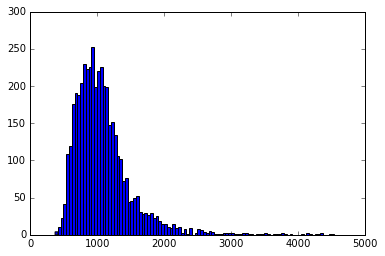

In [79]:
%matplotlib inline

fluxes = []
for ds in ds_list:
    f = ds.get("ip_diffim_NaiveDipoleFlux_pos_flux")
    if f < 5000:
        fluxes.append(f)

plt.hist(fluxes, bins=100)
plt.show()

Creating the stamp on the science exposure

Creating the stamp on the template exposure

Creating the stamp for the subtracted image result

In [57]:
#ds9.mtv(subtractedExposure, frame=4)
im.makeMosaic(frame=4, title="mosaic")

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f5f68ebde70> >

In [59]:
bX = bboxT.getBeginX()
bY = bboxT.getBeginY()
eX = bboxT.getEndX()
eY = bboxT.getEndY()

In [62]:
ds9.line([(bX,bY), (bX, eY)], frame=5,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=5,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=5,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=5,ctype='red')

In [61]:
ds9.line([(bX,bY), (bX, eY)], frame=6,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=6,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=6,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=6,ctype='red')

In [63]:
ds9.line([(bX,bY), (bX, eY)], frame=7,ctype='red')
ds9.line([(bX,eY), (eX, eY)], frame=7,ctype='red')
ds9.line([(eX,eY), (eX, bY)], frame=7,ctype='red')
ds9.line([(eX,bY), (bX, bY)], frame=7,ctype='red')

In [16]:
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=5, size = 25, ctype = ds9.RED)
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=6, size = 25, ctype = ds9.RED)
ds9.dot("o",ds.get("ip_diffim_NaiveDipoleCentroid_pos_x") - scienceExposure.getX0(), ds.get("ip_diffim_NaiveDipoleCentroid_pos_y") - scienceExposure.getY0(), frame=7, size = 25, ctype = ds9.RED)

In [17]:
import lsst.afw.math as afwMath
import lsst.afw.detection as afwDetect

thresholdValue = 50
npixMin        = 5 
grow           = 1
isotropic      = False
maskedImage = subtractedExposure.getMaskedImage()

threshold = afwDetect.Threshold(thresholdValue, afwDetect.Threshold.VALUE)
footPrintSet  = afwDetect.FootprintSet(maskedImage, threshold, "DETECTED", npixMin)
footPrintSet  = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

footPrints = footPrintSet.getFootprints()

footPrintSet.setMask(maskedImage.getMask(), "DETECTED")

In [18]:
print "I found ", footPrints.size(), "footPrint(s)"
print

#for i in range(0,footPrints.size()):
#    print "Footprint:",i
    
#    peak = footPrints[i].getPeaks()[0]
#    print "A peak of value", peak.getPeakValue()
#    print "was found at X =", peak.getFx(),"Y =",peak.getFy()


I found  34727 footPrint(s)



In [19]:
import lsst.meas.algorithms as measAlg

# Make a Schema which is a list of columns for a table.  The object below store things in a table. 
# The Schema is a describption of what is in each column. It can be added to by algorithms later.
schema = afwTable.SourceTable.makeMinimalSchema()

# Make an object which we are going to use to configure the algorithms
# Decide which algorithms to include (meas_algorithms/../tests/measure.py) is a good reference
# Note: the pre-centroid fit is set seperately (it is set by default to 'centroid.sdss')
measureSourcesConfig                  = measAlg.SourceMeasurementConfig()

measureSourcesConfig.algorithms.names = ['shape.sdss']

#Aliases only
measureSourcesConfig.slots.psfFlux    = None
measureSourcesConfig.slots.apFlux     = None
measureSourcesConfig.slots.modelFlux  = None
measureSourcesConfig.slots.instFlux   = None
measureSourcesConfig.validate()

# Now make the object which includes list the algorithms we want to use
# using the measureSourcesConfig object I made before.
# It also adds output places for those algorithms to the schema.
# This object can apply it's algorithms to images given a list of sources.
measureSources = measureSourcesConfig.makeMeasureSources(schema)

# First make a catalog. Then, setup the aliases in the table so that it agrees with 
# our rules above (where we set the aliases to None).
catalog  = afwTable.SourceCatalog(schema)
measureSourcesConfig.slots.setupTable(catalog.getTable())

# Take the set of footPrints (areas around the detected objects) we found when 
# we did the detection and then put them in the catalog.
footPrintSet.makeSources(catalog)

# Loop over all of the sources in the catalog.  For each source apply our measurement algorithms to it.
# It uses the data in the exposure for the calculation.  After the algorithim is run, print the centroid
# of the source as found by the algorithm.  We access it throgh an alias.
for i, source in enumerate(catalog):
    print i
    measureSources.apply(source, exposure)
    print source.getCentroid()

AttributeError: 'module' object has no attribute 'SourceMeasurementConfig'

##Visualization tests

Test methods to paint the sources on the images

In [ ]:
for src1 in diaSrcs1:
    if np.isnan(src1.get("ip_diffim_NaiveDipoleCentroid_pos_x"))==False :
        x = src1.get("ip_diffim_NaiveDipoleCentroid_pos_x")
        y = src1.get("ip_diffim_NaiveDipoleCentroid_pos_y")
        ds9.dot("+", x-cexp.getX0(),y-cexp.getY0(), frame=1, size = 25, ctype = ds9.RED)